In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import numpy as np
import healpy as hp
nside=32

In [3]:
import gc

In [4]:
import pyccl as ccl

cosmo = ccl.Cosmology(Omega_c = 0.262, Omega_b = 0.048, h = 0.69, sigma8 = 0.83, n_s = 0.96)

In [5]:
zs=np.linspace(0,1,100)
dNdz = np.ones(zs.shape)
bias = 1*np.ones(len(dNdz))

In [6]:
clustering = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(zs,dNdz), bias=(zs,bias))
ell = np.arange(0,6144)
cls_clu = ccl.angular_cl(cosmo, clustering, clustering, ell) #Clustering

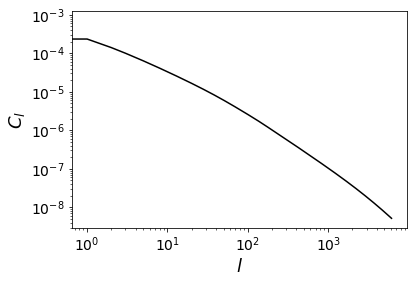

In [7]:
plt.xlabel('$l$',fontsize=18)
plt.ylabel('$C_l$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ell, cls_clu, 'k-')
plt.show()

In [8]:
fakeOverdensity = hp.synfast(cls_clu,nside=nside)

/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


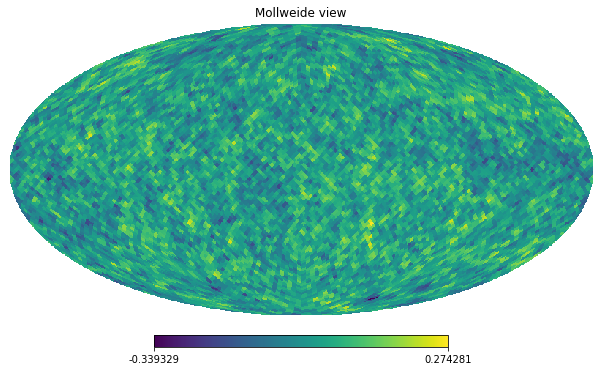

In [9]:
hp.mollview(fakeOverdensity)

# Use kSZ map to get fake kSZ Maps

In [10]:
kSZMap = hp.read_map("./kSZ_NS_2048_R_2048_P_2560_DV_256.fits")

/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [11]:
kSZPowSpec = hp.anafast(kSZMap)

In [12]:
fakekSZ = hp.synfast(kSZPowSpec,nside=nside)

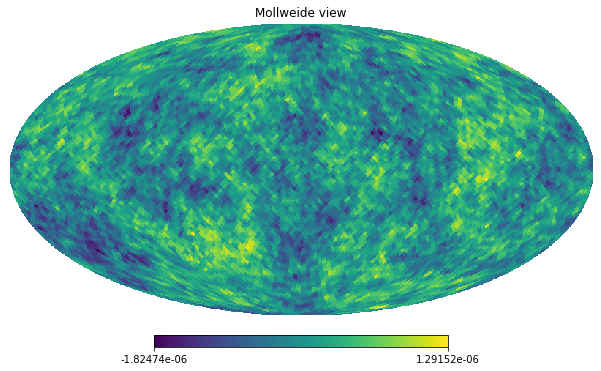

In [13]:
hp.mollview(fakekSZ)

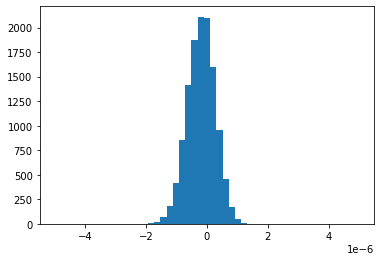

In [14]:
#Need the +1 because a -1 overdensity really means no particles (i.e. overdensity+1 is the value that is directly proportional to mass)
fakeVel = fakekSZ/(fakeOverdensity+1)
plt.hist(fakeVel,bins = np.linspace(-5*10**-6,5*10**-6));

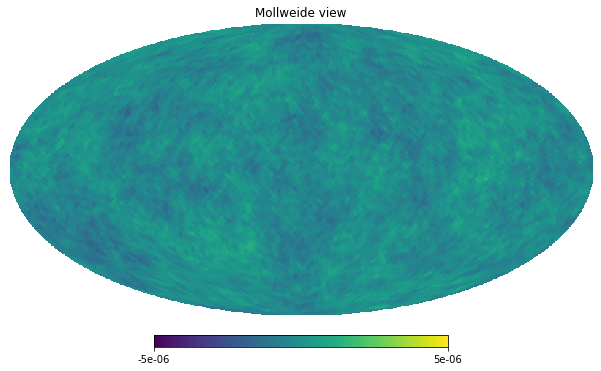

In [15]:
hp.mollview(fakeVel,min = -5*10**-6,max=5*10**-6)

# Make 200 fake maps

In [16]:
import sys

In [17]:
sizeOfOneSet = 3*sys.getsizeof(fakeVel)/(1*10**9)

In [18]:
#This is how many data triplets I can fit in memory
25/sizeOfOneSet

84681.46221174429

In [19]:
numSets = 10000

overdensData = np.zeros((numSets,12*nside**2))
kSZData = np.zeros((numSets,12*nside**2))
velData = np.zeros((numSets,12*nside**2))

for i in range(0,numSets):
    overdensData[i] = hp.synfast(cls_clu,nside=nside)
    kSZData[i] = hp.synfast(kSZPowSpec,nside=nside)
    velData[i] = kSZData[i]/(overdensData[i]+1)

In [20]:
from deepsphere import HealpyGCNN
from deepsphere import healpy_layers as hp_layer
from deepsphere import utils

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_probability as tfp

In [21]:
x_raw = np.stack((overdensData,kSZData),axis=2)
x_raw = np.reshape(x_raw,(numSets,2*12*nside**2))

x_train, x_test = np.split(x_raw, indices_or_sections=[numSets-numSets//10])
y_train, y_test = np.split(velData, indices_or_sections=[numSets-numSets//10])

In [22]:
del overdensData
del kSZData
del velData
del x_raw
gc.collect()

0

In [23]:
# dset_test = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_test),
#                                  tf.data.Dataset.from_tensor_slices(y_test)))
# dset_test = dset_test.batch(16)

# dset_train = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train),
#                                   tf.data.Dataset.from_tensor_slices(y_train)))                                
# dset_train = dset_train.batch(16)

In [24]:
layersMod = [# this is a graph convolutional layer, it preserves the shape of the input
          hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          # another graph convolutional layer, it preserves the shape of the input
          hp_layer.HealpyMonomial(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          # a residual layer using graph convolutions
          hp_layer.Healpy_ResidualLayer(layer_type="CHEBY", 
                                        layer_kwargs={"K": 10, "activation": "relu",
                                                      "use_bn": True, "use_bias": True},
                                        use_bn=False,
                                        activation="relu", alpha=0.1),
          tf.keras.layers.Dense(1, activation="sigmoid"),
          tf.keras.layers.Flatten()
      ]

In [25]:
tf.keras.backend.clear_session()
modelHP = HealpyGCNN(nside=nside, layers=layersMod,indices=np.arange(0,12*nside**2), n_neighbors=8)

Detected a reduction factor of 1.0, the input with nside 32 will be transformed to 32 during a forward pass. Checking for consistency with indices...
indices seem consistent...


In [26]:
padded_pixel = np.arange(0,12*nside**2)
modelHP.build(input_shape=(None, len(padded_pixel), 1))
modelHP.summary(110)

Model: "healpy_gcnn_1"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 chebyshev (Chebyshev)                           (None, 12288, 5)                            65               
                                                                                                              
 monomial (Monomial)                             (None, 12288, 5)                            265              
                                                                                                              
 gcnn__residual_layer (GCNN_ResidualLayer)       (None, 12288, 5)                            530              
                                                                                                              
 dense (Dense)                                   (None, 12288, 1)                        

In [27]:
model = models.Sequential()
model.add(tf.keras.Input(shape=(2*12*nside**2)))
model.add(tf.keras.layers.Dense(12*nside**2, activation='relu'))
model.add(tf.keras.layers.Dense(12*nside**2, activation='relu'))

In [28]:
model.build()

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12288)             302002176 
                                                                 
 dense_1 (Dense)             (None, 12288)             151007232 
                                                                 
Total params: 453,009,408
Trainable params: 453,009,408
Non-trainable params: 0
_________________________________________________________________


In [30]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.Huber(delta=1.0,reduction="auto",name="huber_loss"),
#               metrics=[r_square])

In [ ]:
# history = model.fit(x_train,y_train,epochs=10,validation_data=(x_test, y_test))

In [31]:
inputs = tf.keras.Input(shape=(2*12*nside**2))
x = model(inputs, training=True)
outputs = modelHP(x)
modelTot = tf.keras.Model(inputs,outputs)

In [32]:
modelTot.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24576)]           0         
                                                                 
 sequential (Sequential)     (None, 12288)             453009408 
                                                                 
 healpy_gcnn_1 (HealpyGCNN)  (None, 12288)             866       
                                                                 
Total params: 453,010,274
Trainable params: 453,010,234
Non-trainable params: 40
_________________________________________________________________


In [33]:
modelTot.build(input_shape=(None,2*12*nside**2))

In [34]:
modelTot.compile(optimizer='adam',
              loss=tf.keras.losses.Huber(delta=1.0,reduction="auto",name="huber_loss"),
              metrics=[r_square])

In [ ]:
history = modelTot.fit(x_train,y_train,epochs=25,validation_data=(x_test, y_test))
#history = modelTot.fit(dset_train,epochs=25,validation_data=(dset_test))

Epoch 1/25
282/282 [==============================] - 401s 1s/step - loss: 0.0869 - r_square: -324011982848.0000 - val_loss: 0.0599 - val_r_square: -220442296320.0000
Epoch 2/25
282/282 [==============================] - 399s 1s/step - loss: 0.0426 - r_square: -158679433216.0000 - val_loss: 0.0282 - val_r_square: -103810367488.0000
Epoch 3/25
153/282 [===============>..............] - ETA: 3:00 - loss: 0.0231 - r_square: -86451372032.0000